In [1]:
import os
import torch
from tqdm.auto import tqdm
import time
os.environ['http_proxy'] = "http://192.41.170.23:3128" 
os.environ['https_proxy'] = "http://192.41.170.23:3128" 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
from datasets import load_dataset
sst = load_dataset("sst2")
sst 

Found cached dataset sst2 (/home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [3]:
trainsst = sst['train']
valsst = sst['validation']
testsst = sst['test']
trainsst

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 67349
})

In [4]:
from transformers import AutoTokenizer , AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [5]:
def tokenize_function(examples):
    return tokenizer(examples["prompts"], padding="max_length", truncation=True)

# making label for Masking task. 0 : negative , 1 : positive 
def adjust_label(dataset):
    # dataset might NOT covert to tensor format.
    label_0 = tokenizer("negative")["input_ids"][1]
    label_1 = tokenizer("positive")["input_ids"][1]
    
    pad_length = len(dataset["input_ids"][0])
    num_sample = len(dataset)
    mock_labels = [[-100]*pad_length]*num_sample
    mock_labels = torch.LongTensor(mock_labels)
    # x = x.add_column('la99',mock_labels)
    dataset.set_format("torch")
    
    # repalce value in labels array for tranform to MLM patterns
    start = time.time()
    progress_bar = tqdm(range(len(dataset)))
    for i in range(len(dataset)) :
        cls_token_index = torch.where(dataset["input_ids"][i] == tokenizer.cls_token_id)
        cls_token_index = cls_token_index[0].item()
        mock_labels[i][cls_token_index] = tokenizer.cls_token_id

        sep_token_index = torch.where(dataset["input_ids"][i] == tokenizer.sep_token_id)
        sep_token_index = sep_token_index[0].item()
        mock_labels[i][sep_token_index] = tokenizer.sep_token_id

        mask_token_index = torch.where(dataset["input_ids"][i] == tokenizer.mask_token_id)
        mask_token_index = mask_token_index[0].item()
        if dataset['label'][i] == 0 : 
            mock_labels[i][mask_token_index] = label_0
        elif  dataset['label'][i] == 1 :
            mock_labels[i][mask_token_index] = label_1
        else :
            assert False , "something wrong!!"
        progress_bar.update(1)
         
    dataset = dataset.add_column('labels',mock_labels.tolist())
    end = time.time()
    print("Time : ",end - start)
    
    return dataset

In [6]:
# prompting data then tokenization 
def token_data(dataset,template):
    if template == 1 : 
        prompts = list(map(lambda sentence : sentence + ": " + "[MASK]"        , dataset["sentence"]))
    elif template == 2 : 
        prompts = list(map(lambda sentence : sentence + ", " + "[MASK]"        , dataset["sentence"]))
    elif template == 3 : 
        prompts = list(map(lambda sentence : sentence + "(" + "[MASK]" + ")"    , dataset["sentence"]))
    elif template == 4 : 
        prompts = list(map(lambda sentence : sentence + "=" + "[MASK]"         , dataset["sentence"]))
    else : 
        assert False , "something wrong!!"
    dataset = dataset.add_column('prompts',prompts)
    dataset = dataset.remove_columns(['sentence'])
    
    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = adjust_label(tokenized_datasets)
    tokenized_datasets = tokenized_datasets.remove_columns(["prompts","idx",'label'])
    
    return tokenized_datasets

In [7]:
small_train = trainsst.shuffle(seed=42).select(range(8000))
train_dataset_1 = token_data(small_train,1)
train_dataset_2 = token_data(small_train,2)
train_dataset_3 = token_data(small_train,3)
train_dataset_4 = token_data(small_train,4)

small_eval = valsst.shuffle(seed=42).select(range(800))
eval_dataset_1 = token_data(small_eval,1)
eval_dataset_2 = token_data(small_eval,2)
eval_dataset_3 = token_data(small_eval,3)
eval_dataset_4 = token_data(small_eval,4)

Loading cached shuffled indices for dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-2459d1a782cafb86.arrow
Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-cbbac5dc6e46e40a.arrow
Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-836047637baa27a8.arrow


  0%|          | 0/8000 [00:00<?, ?it/s]

Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-cbbac5dc6e46e40a.arrow
Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-1084d77ce90df77d.arrow


Time :  332.408216714859


  0%|          | 0/8000 [00:00<?, ?it/s]

Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-cbbac5dc6e46e40a.arrow
Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-273469ad057a3d1f.arrow


Time :  343.8673324584961


  0%|          | 0/8000 [00:00<?, ?it/s]

Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-cbbac5dc6e46e40a.arrow
Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-31988bd48168ce45.arrow


Time :  341.3421037197113


  0%|          | 0/8000 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-f4e698265d2128b9.arrow
Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-7a0ab150ff7e2d19.arrow
Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-86c6056046fa88ec.arrow


Time :  337.58317708969116


  0%|          | 0/800 [00:00<?, ?it/s]

Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-7a0ab150ff7e2d19.arrow
Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-3edcd15f44a42e51.arrow


Time :  4.403248310089111


  0%|          | 0/800 [00:00<?, ?it/s]

Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-7a0ab150ff7e2d19.arrow
Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-047f8daa115e8ac2.arrow


Time :  4.115425109863281


  0%|          | 0/800 [00:00<?, ?it/s]

Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-7a0ab150ff7e2d19.arrow
Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-4b6550e708072178.arrow


Time :  4.300906419754028


  0%|          | 0/800 [00:00<?, ?it/s]

Time :  4.243851661682129


In [8]:
from torch.utils.data import DataLoader
batch_size = 8 

train_dataloader_1 = DataLoader(train_dataset_1, shuffle=True, batch_size=batch_size)
train_dataloader_2 = DataLoader(train_dataset_2, shuffle=True, batch_size=batch_size)
train_dataloader_3 = DataLoader(train_dataset_3, shuffle=True, batch_size=batch_size)
train_dataloader_4 = DataLoader(train_dataset_4, shuffle=True, batch_size=batch_size)

eval_dataloader_1 = DataLoader(eval_dataset_1, batch_size=batch_size)
eval_dataloader_2 = DataLoader(eval_dataset_2, batch_size=batch_size)
eval_dataloader_3 = DataLoader(eval_dataset_3, batch_size=batch_size)
eval_dataloader_4 = DataLoader(eval_dataset_4, batch_size=batch_size)

In [10]:
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

from accelerate import Accelerator
model_1 = model 
model_2 = model
model_3 = model 
model_4 = model

accelerator_1 = Accelerator()
model_1, optimizer, train_dataloader_1, eval_dataloader_1 = accelerator_1.prepare(
    model_1, optimizer, train_dataloader_1, eval_dataloader_1
)

accelerator_2 = Accelerator()
model_2, optimizer, train_dataloader_2, eval_dataloader_2 = accelerator_2.prepare(
    model_2, optimizer, train_dataloader_2, eval_dataloader_2
)

accelerator_3 = Accelerator()
model_3, optimizer, train_dataloader_3, eval_dataloader_3 = accelerator_3.prepare(
    model_3, optimizer, train_dataloader_3, eval_dataloader_3
)

accelerator_4 = Accelerator()
model_4, optimizer, train_dataloader_4, eval_dataloader_4 = accelerator_4.prepare(
    model_4, optimizer, train_dataloader_4, eval_dataloader_4
)


In [11]:
from transformers import get_scheduler

num_train_epochs = 10
num_update_steps_per_epoch = len(train_dataloader_1)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [12]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
torch.cuda.get_device_name(device)

'NVIDIA RTX A6000'

In [13]:
def train_model(model,train_dataloader,accelerator):
    losses = []
    model.train()
    progress_bar = tqdm(range(num_update_steps_per_epoch))
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()} 
        outputs = model(**batch)
        loss = outputs.loss
        losses.append(loss)
        accelerator.backward(loss)
        
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    return model,losses 

def eval_model(model,eval_dataloader,accelerator):
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))
    losses = torch.cat(losses)
    losses = losses[: len(eval_dataloader)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")
    return model , perplexity 

In [14]:
from tqdm.auto import tqdm
import torch
import math

#progress_bar = tqdm(range(num_training_steps))
losses_1 = []
losses_2 = []
losses_3 = []
losses_4 = []

perplexities_1 = []
perplexities_2 = []
perplexities_3 = []
perplexities_4 = []

best_1 , best_2 ,best_3, best_4 = 9999999,9999999,9999999,9999999
for epoch in range(num_train_epochs):

    model_1 , losses = train_model(model_1,train_dataloader_1,accelerator_1)
    model_1 , perplexity =  eval_model(model_1,eval_dataloader_1,accelerator_1)
    perplexities_1.append(perplexity)
    losses_1 += losses
    
    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")
    
    model_2 ,losses= train_model(model_2,train_dataloader_2,accelerator_2)
    model_2 , perplexity =  eval_model(model_2,eval_dataloader_2,accelerator_2)
    perplexities_2.append(perplexity)
    losses_2 += losses
    
    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")
    
    model_3,losses = train_model(model_3,train_dataloader_3,accelerator_3)
    model_3 , perplexity =  eval_model(model_3,eval_dataloader_3,accelerator_3)
    perplexities_3.append(perplexity)
    losses_3 += losses
    
    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")
    
    model_4,losses = train_model(model_4,train_dataloader_4,accelerator_4)
    model_4 , perplexity =  eval_model(model_4,eval_dataloader_4,accelerator_4)
    perplexities_4.append(perplexity)
    losses_4 += losses
    
    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")
    
    if perplexities_1[-1] < best_1:
        best_1 = perplexities_1[-1]
        model_1.save_pretrained("model/model_1/2401"+str(epoch), from_pt=True)
        
    if perplexities_2[-1] < best_2:
        best_2 = perplexities_2[-1]
        model_2.save_pretrained("model/model_2/2401"+str(epoch), from_pt=True)      
        
    if perplexities_3[-1] < best_3:
        best_3 = perplexities_3[-1]
        model_3.save_pretrained("model/model_3/2401"+str(epoch), from_pt=True)
        
    if perplexities_4[-1] < best_4:
        best_4 = perplexities_4[-1]
        model_4.save_pretrained("model/model_3/2401"+str(epoch), from_pt=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 0: Perplexity: 1.1281556406266984


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 0: Perplexity: 1.1326004235986353


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 0: Perplexity: 1.162828682476021


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 0: Perplexity: 1.2174879540377197


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 1: Perplexity: 1.251638799649102


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 1: Perplexity: 1.2135846812189


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 1: Perplexity: 1.3042150127052945


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 1: Perplexity: 1.284901952112451


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 2: Perplexity: 1.2838726450211062


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 2: Perplexity: 1.2608504576745374


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 2: Perplexity: 1.272557324924781


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 2: Perplexity: 1.2563496018196751


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 3: Perplexity: 1.2530733509133336


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 3: Perplexity: 1.2608504576745374


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 3: Perplexity: 1.272557324924781


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 3: Perplexity: 1.2563496018196751


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 4: Perplexity: 1.2530733509133336


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 4: Perplexity: 1.2608504576745374


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 4: Perplexity: 1.272557324924781


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 4: Perplexity: 1.2563496018196751


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 5: Perplexity: 1.2530733509133336


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 5: Perplexity: 1.2608504576745374


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 5: Perplexity: 1.272557324924781


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 5: Perplexity: 1.2563496018196751


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 6: Perplexity: 1.2530733509133336


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 6: Perplexity: 1.2608504576745374


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 6: Perplexity: 1.272557324924781


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 6: Perplexity: 1.2563496018196751


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 7: Perplexity: 1.2530733509133336


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 7: Perplexity: 1.2608504576745374


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 7: Perplexity: 1.272557324924781


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 7: Perplexity: 1.2563496018196751


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 8: Perplexity: 1.2530733509133336


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 8: Perplexity: 1.2608504576745374


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 8: Perplexity: 1.272557324924781


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 8: Perplexity: 1.2563496018196751


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 9: Perplexity: 1.2530733509133336


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 9: Perplexity: 1.2608504576745374


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 9: Perplexity: 1.272557324924781


  0%|          | 0/1000 [00:00<?, ?it/s]

>>> Epoch 9: Perplexity: 1.2563496018196751


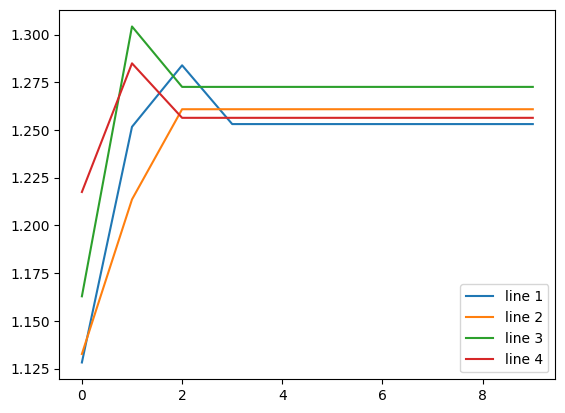

In [15]:
import matplotlib.pyplot as plt
plt.plot(perplexities_1,label = "line 1") 
plt.plot(perplexities_2,label = "line 2") 
plt.plot(perplexities_3,label = "line 3") 
plt.plot(perplexities_4,label = "line 4")
plt.legend()
plt.show()

In [16]:
def to_cpu(losses):
    return losses.cpu().detach().numpy()
loss_1 = map(to_cpu,losses_1)
loss_2 = map(to_cpu,losses_2)
loss_3 = map(to_cpu,losses_3)
loss_4 = map(to_cpu,losses_4)

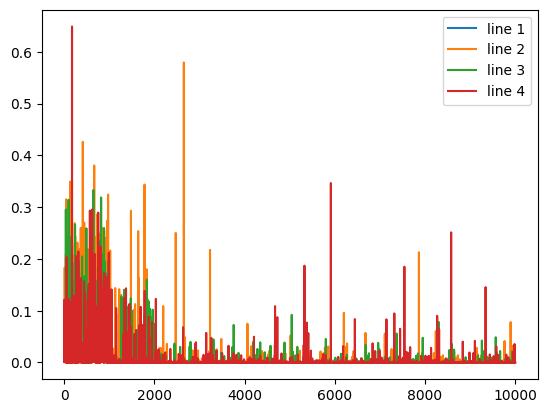

In [21]:
plt.plot(list(loss_1),label = "line 1") 
plt.plot(list(loss_2),label = "line 2") 
plt.plot(list(loss_3),label = "line 3") 
plt.plot(list(loss_4),label = "line 4")
plt.legend()
plt.show()